Inspired by:
https://nextjournal.com/gkoehler/pytorch-mnist

## Imports

In [12]:
# Imports
import torch
import torch.nn as nn
import torch.optim as optim
import torchvision
import torchvision.transforms as transforms
import torch.nn.functional as F
import matplotlib.pyplot as plt
from torch.utils.data import DataLoader, random_split

## Set parameters

In [13]:
torch.manual_seed(42)

In [14]:
batch_size_train = 64

In [15]:
batch_size_test = 500
transform = transforms.Compose([
    transforms.ToTensor(), # Transform to tensor, so scale data to [0.1] range
    transforms.Normalize((0.1307,),(0.3081,)) # Scale to have zero mean and standard deviation. Values of mean and STD taken as given.
])

## Load Data

In [16]:
full_train_data = torchvision.datasets.MNIST("/files/", train=True, transform=transform, download=True)

# Split into training (80%) and validation (20%)
train_size = int(0.8 * len(full_train_data))  
val_size = len(full_train_data) - train_size  

train_dataset, val_dataset = random_split(full_train_data, [train_size, val_size])

train_loader = DataLoader(train_dataset, batch_size=batch_size_train, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=batch_size_train, shuffle=False)


In [17]:
# Load test data
test_loader = torch.utils.data.DataLoader(torchvision.datasets.MNIST('/files/', 
                                                                      train=False, download=True, 
                                                                      transform=transform),
                                                                      batch_size=batch_size_test, shuffle=True)

In [18]:
# Get a batch of the test data. Shape shold be %batch_size_test, 1, 28, 28
examples = enumerate(test_loader)
batch_idx, (example_data, example_targets) = next(examples)

In [19]:
example_data.shape

torch.Size([500, 1, 28, 28])

## Example of datapoints

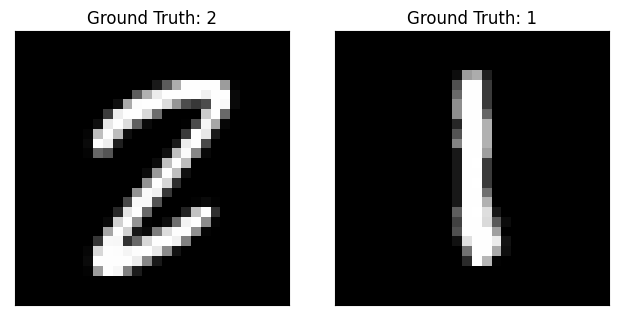

In [20]:
# Print examples of datapoints from the set
fig = plt.figure()
for i in range(2):
  plt.subplot(1,2,i+1)
  plt.tight_layout()
  plt.imshow(example_data[i][0], cmap='gray', interpolation='none')
  plt.title("Ground Truth: {}".format(example_targets[i]))
  plt.xticks([])
  plt.yticks([])
plt.show()

## Network Classes

### Parent network class

In [21]:
# Parent class for the network, so both a network with linear layers and a CNN network can be tested.
class DigitClassifier(nn.Module):
    
    def __init__(self) -> None:
        super(DigitClassifier, self).__init__()

    def forward(self, x):
        raise NotImplementedError("Subclasses must implement forward method") 

    # A function tha trains the network based on the given train data, optimizer and criterion.
    # args:
    # @train_loader -> The dataloader for the train data
    # @optimizer ->  The optimizer to be used during training
    # @criterion -> The criterion to be used for training
    # @num_epochs -> The number of epochs to train for
    # @verbose -> Set to True if training updates are to be printed out
    def train_model(self, train_loader, optimizer, criterion, num_epochs=10, verbose=True):
        for epoch in range(num_epochs):
            running_loss = 0.0
            for images, labels in train_loader:
                optimizer.zero_grad()  # Reset gradients
                outputs = self(images)  # Forward pass
                loss = criterion(outputs, labels)  # Compute loss
                loss.backward()  # Backpropagation
                optimizer.step()  # Update weights

                running_loss += loss.item()
            if verbose:
                print(f"Epoch {epoch+1}, Loss: {running_loss/len(train_loader)}")
        if verbose:
            print("Training Complete!")
        return running_loss/len(train_loader)

    # A function that runs the model on test data.
    # args:
    # @test_loader -> The dataloader for the test data
    # @verbose -> Set to True if test accuracy is to be printed out
    def test_model(self, test_loader, verbose=True):
        correct = 0
        total = 0

        self.eval()

        with torch.no_grad():  # No need to track gradients
            for images, labels in test_loader:
                outputs = self(images)
                _, predicted = torch.max(outputs, 1)  # Get class with highest probability
                total += labels.size(0)
                correct += (predicted == labels).sum().item()

        accuracy = 100 * correct / total
        
        if verbose:
            print(f"Test Accuracy: {accuracy:.2f}%")

        return accuracy



### Linear Network Class

In [22]:
# A subclass of DigitClassifier that uses only linear layers and relu activation layers
class LinearDigitClassifier(DigitClassifier):
    
    def __init__(self) -> None:
        super(LinearDigitClassifier, self).__init__()

        self.fc1 = nn.Linear(784, 128)
        self.fc2 = nn.Linear(128, 64)
        self.fc3 = nn.Linear(64, 10)

    def forward(self, x):
        x = x.view(-1, 28*28)
        x = F.relu(self.fc1(x))
        x = F.relu(self.fc2(x))
        x = F.relu(self.fc3(x))
        return F.log_softmax(x, -1)


### CNN Network Class

In [23]:
# A subclass of DigitClassifier that uses Convolutional Layers and maxpooling
class CNNDigitClassifier(DigitClassifier):
    
    def __init__(self) -> None:
        super(CNNDigitClassifier, self).__init__()

        self.conv1 = nn.Conv2d(1, 16, kernel_size=3)
        self.conv2 = nn.Conv2d(16, 32, kernel_size=3)
        self.conv2_drop = nn.Dropout2d()
        self.fc1 = nn.Linear(800, 50)
        self.fc2 = nn.Linear(50, 10)

    def forward(self, x):
        x = F.relu(F.max_pool2d(self.conv1(x), 2))
        x = F.relu(F.max_pool2d(self.conv2_drop(self.conv2(x)), 2))
        x = x.view(-1, 800)
        x = F.relu(self.fc1(x))
        x = F.dropout(x, training=self.training)
        x = self.fc2(x)
        return F.log_softmax(x, -1)

## Test CNN Network to find best Learning Rate and Momentum

In [24]:
# Arrays to store accuracy in validation set for differnt learning rate and error in training set
val_lr = []
train_lr = []

# Same, but for different momentum values
val_momentum = []
train_momentum =[]

# Different learning rates and momentum values to test
learning_rates = [0.1, 0.01, 0.001, 0.0001]
momentums = [0.5, 0.9, 0.95]

# Number of epochs to run training for
epochs = 10

# Criterion to use during training
criterion = nn.CrossEntropyLoss()

### Choose Learning Rate

In [25]:

for lr in learning_rates:
    network = CNNDigitClassifier()
    optimizer = optim.SGD(network.parameters(), lr = lr)
    train_acc = network.train_model(train_loader, optimizer, criterion, epochs, verbose=False)
    val_acc = network.test_model(val_loader, verbose=False)
    val_lr.append(val_acc)
    train_lr.append(train_acc)



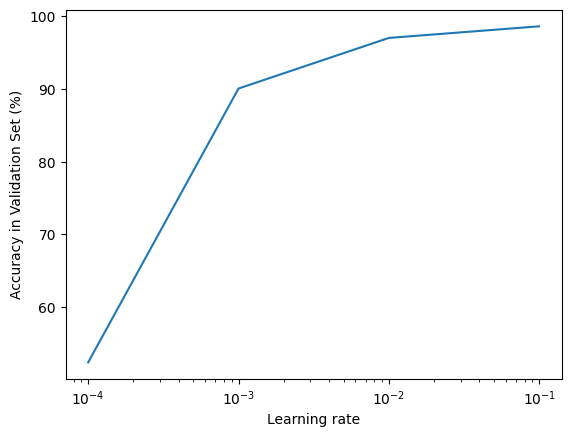

In [26]:
fig, ax = plt.subplots(1, 1)
ax.plot(learning_rates, val_lr)
ax.set_xlabel("Learning rate")
ax.set_ylabel("Accuracy in Validation Set (%)")
ax.set_xticks(learning_rates)
ax.set_xscale('log')
plt.show()

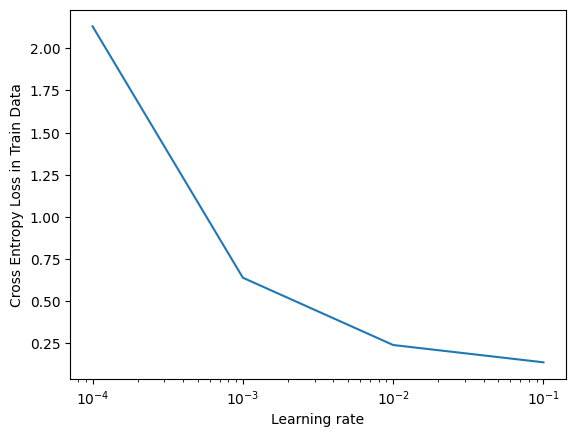

In [27]:
fig, ax = plt.subplots(1, 1)
ax.plot(learning_rates, train_lr)

ax.set_ylabel("Cross Entropy Loss in Train Data")
ax.set_xlabel("Learning rate")
ax.set_xticks(learning_rates)
ax.set_xscale('log')
plt.show()

#### Choosing a learning rate of 0.1

### Choosing Momentum

In [28]:
for momentum in momentums:
    network = CNNDigitClassifier()
    optimizer = optim.SGD(network.parameters(), lr = 0.1, momentum=momentum)
    train_acc = network.train_model(train_loader, optimizer, criterion, epochs, verbose=False)
    val_acc = network.test_model(val_loader, verbose=False)
    val_momentum.append(val_acc)
    train_momentum.append(train_acc)

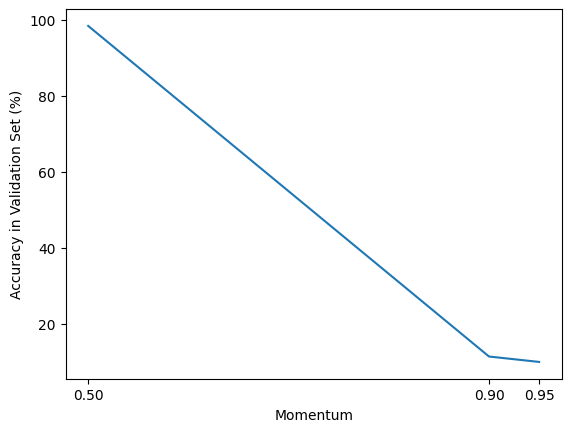

In [29]:
fig, ax = plt.subplots(1, 1)
ax.plot(momentums, val_momentum)
ax.set_xlabel("Momentum")
ax.set_ylabel("Accuracy in Validation Set (%)")
ax.set_xticks(momentums)
plt.show()

#### Choosing a momentum of 0.5

## Running the network with learning_rate = 0.1, momentum=0.5

In [35]:
network = CNNDigitClassifier()
optimizer = optim.SGD(network.parameters(), lr = 0.1, momentum=0.5)
network.train_model(train_loader, optimizer, criterion, epochs)

Epoch 1, Loss: 0.477016002257665
Epoch 2, Loss: 0.24637179404000442
Epoch 3, Loss: 0.2099054195433855
Epoch 4, Loss: 0.19212953802446525
Epoch 5, Loss: 0.17756037823110818
Epoch 6, Loss: 0.17401542960728208
Epoch 7, Loss: 0.1622748806029558
Epoch 8, Loss: 0.15136730731651188
Epoch 9, Loss: 0.1504239497296512
Epoch 10, Loss: 0.15166102923701208
Training Complete!


0.15166102923701208

## Run the model on the validation and test data

In [36]:
network.test_model(val_loader)

Test Accuracy: 98.50%


98.5

In [37]:
network.test_model(test_loader)

Test Accuracy: 98.62%


98.62

## Test on a random data point of the test set

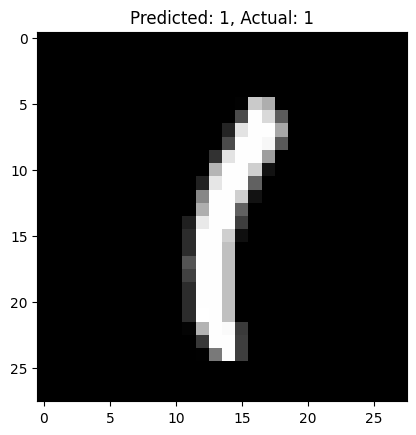

In [38]:
# Get a random test image
images, labels = next(iter(test_loader))
image = images[0].numpy().squeeze()

# Get prediction
output = network(images[0].unsqueeze(0))
_, predicted = torch.max(output, 1)

# Show image and prediction
plt.imshow(image, cmap="gray")
plt.title(f"Predicted: {predicted.item()}, Actual: {labels[0].item()}")
plt.show()

In [39]:
torch.save(network.state_dict(), "mnist_model.pth")